In [2]:
import pandas as pd
import numpy as np

In [3]:
def load(file):
    """Load the experiment data from a CSV file"""
    
    schema = {
        'First': np.int64(),
        'Last': np.int64(),
        'Parse': np.float64(),
        'Resize': np.float64(),
        'Serialize': np.float64(),
        'Pop': np.float64(),
    }
    
    df = pd.read_csv(file, dtype=schema)
    df.file = file

    return df

In [4]:
import os

def get_meta(path):
    """Returns (threads, num_jsons, repeats)"""
    props = os.path.splitext(os.path.basename(file))[0].split('_')
    return (int(props[1][1:]), int(props[2][1:]), int(props[3][1:]))

def analyze(df):
    """Analyze the experiment data, deriving various metrics."""
    
    df['Total'] = df['Parse'] + df['Resize'] + df['Serialize'] + df['Pop']
    df.threads, df.jsons, df.repeats = get_meta(df.file)
        
    return df

In [5]:
def summarize(df):
    """Summarize the data from all threads into one row."""
    
    row = {'Threads': df.threads,
           'JSONs': df.jsons,
           'Parse': df['Parse'].mean(),
           'Resize': df['Resize'].mean(),
           'Serialize': df['Serialize'].mean(),
           'Pop': df['Pop'].mean(),
           'Total': df['Total'].mean()}
              
    return row;

In [6]:
def make_summary_df(records):
    df = pd.DataFrame.from_records(records)
    df.sort_values(by=['Threads', 'JSONs'], inplace=True)
    df.set_index(['Threads'], inplace=True)
    df.Parse = df.Parse * 1e-9
    df.Resize = df.Resize * 1e-9
    df.Serialize = df.Serialize * 1e-9
    df.Pop = df.Pop * 1e-9
    df.Total = df.Total * 1e-9
    
    return df

In [14]:
import glob

cpu_files = []
for file in glob.glob("../experiments/data/battery/latency/threads/latency/custom/*.csv"):
    cpu_files.append(file)

cpu_records = []
for file in cpu_files:
    cpu_records.append(summarize(analyze(load(file))))

fpga_files = []
for file in glob.glob("../experiments/data/battery/latency/threads/latency/fpga/*.csv"):
    fpga_files.append(file)
    
fpga_records = []
for file in fpga_files:
    fpga_records.append(summarize(analyze(load(file))))

In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

df = make_summary_df(cpu_records)
dff = make_summary_df(fpga_records)
dff.set_index('JSONs', inplace=True)

display(df)
display(dff)

,JSONs,Parse,Resize,Serialize,Pop,Total
Threads,,,,,,
1,1,0.000081,5.502500e-07,0.000011,0.000002,0.000094
1,2,0.000111,5.921250e-07,0.000012,0.000011,0.000135
1,4,0.000133,6.340625e-07,0.000012,0.000013,0.000159
1,8,0.000127,5.505625e-07,0.000011,0.000007,0.000145
1,16,0.000116,5.982500e-07,0.000013,0.000007,0.000137
1,32,0.000106,2.900000e-07,0.000007,0.000011,0.000124
1,64,0.000140,6.146563e-07,0.000013,0.000005,0.000159
1,128,0.000183,5.806250e-07,0.000013,0.000008,0.000204
1,256,0.000213,5.953125e-07,0.000016,0.000014,0.000243


,Parse,Resize,Serialize,Pop,Total
JSONs,,,,,
16,0.000286,8.248613e-07,0.000295,0.000008,0.000589
32,0.000267,1.083789e-06,0.000350,0.000012,0.000629
64,0.000265,7.615742e-07,0.000278,0.000007,0.000550
128,0.000261,9.750430e-07,0.000346,0.000010,0.000618
256,0.000329,8.697637e-07,0.000302,0.000007,0.000639
512,0.000268,9.105801e-07,0.000386,0.000010,0.000664
1024,0.000268,8.712324e-07,0.000299,0.000005,0.000573
2048,0.000274,8.676055e-07,0.000387,0.000006,0.000668
4096,0.000271,7.697559e-07,0.000318,0.000008,0.000598


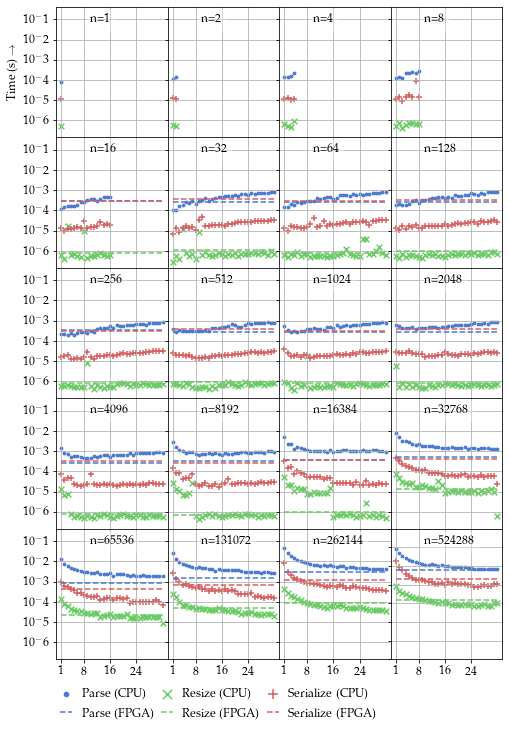

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 12
})

num_jsons = df.JSONs.unique()
num_jsons.sort()

ymax = 4*df.Total.max()
ymin = df.Resize.min() / 2
tmin = df.index.min()
tmax = df.index.max()

cols = 4
rows = int(math.ceil(len(num_jsons)/cols))

xticks = list(range(0,tmax,8))
xticks[0] = 1

yrange = range(round(math.log10(ymin)), 1, 1)
yticks = [10**x for x in yrange]
yticklabels = ['$10^{}$'.format(x) for x in yrange]
yticklabels[-1] = str(1)

colors = ['#4878d0', '#6acc64', '#d65f5f', '#d5bb67', '#dc7ec0', '#8c613c']
markers = ['.','x','+']
msize = 32

fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=[8, 12], sharex='all', sharey='all')
plt.subplots_adjust(wspace=0, hspace=0)
for i, n in enumerate(num_jsons):
    # Determine where to draw
    row = int(i / cols)
    col = i % cols
    ax = axs[row][col]
    
    # Determine which experiment to draw
    subdf = df[df.JSONs == n]
    del subdf['JSONs']
    del subdf['Total']
    
    # Draw points
    ppa=ax.scatter(x=subdf.index, y=subdf.Parse, label='Parse', c=colors[0], marker=markers[0], s=msize)
    pre=ax.scatter(x=subdf.index, y=subdf.Resize, label='Resize', c=colors[1], marker=markers[1], s=msize)
    pse=ax.scatter(x=subdf.index, y=subdf.Serialize, label='Serialize', c=colors[2], marker=markers[2], s=msize)
    
    # Draw FPGA horizontal lines
    if n >= dff.index.min():
        fpa=ax.hlines(y=dff.loc[n].Parse, xmin=tmin, xmax=tmax, colors=colors[0], linestyle='dashed')
        fre=ax.hlines(y=dff.loc[n].Resize, xmin=tmin, xmax=tmax, colors=colors[1], linestyle='dashed')
        fse=ax.hlines(y=dff.loc[n].Serialize, xmin=tmin, xmax=tmax, colors=colors[2], linestyle='dashed')
    
    # Set title
    ax.annotate('n={}'.format(n), xycoords='axes fraction', xy=(0.3, 0.88), backgroundcolor=(1, 1, 1, 0.33))
    
    # Set labels
    if col == 0 and row == 0:
        ax.set_ylabel('Time (s) →')
    else:
        ax.set_ylabel('')
    
    if col == cols-1 and row == rows-1:
        ax.set_xlabel('Threads →')
    else:
        ax.set_xlabel('')
    
    # Set limits and scale
    axs[row][col].set_ylim([ymin, ymax])
    axs[row][col].set_yscale('log')

    # Set ticks and grid
    ax.set_xlabel(None)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.grid(which='both')
            
fig.legend([ppa, fpa, pre, fre, pse, fse], ['Parse (CPU)', 'Parse (FPGA)', 
                                            'Resize (CPU)', 'Resize (FPGA)',
                                            'Serialize (CPU)', 'Serialize (FPGA)'], 
#fig.legend([ppa,  pre,  pse], ['Parse (CPU)', 'Resize (CPU)', 'Serialize (CPU)',], 
           ncol=3, 
           bbox_to_anchor=(0.2, -0.395, 0.5, 0.5), 
           frameon=None, shadow=None, framealpha=0.0,
           markerscale=1.64,
           columnspacing=0.6,
           handlelength=1.0)
    
fig.savefig('jsonsthreadstime.pdf', bbox_inches='tight')


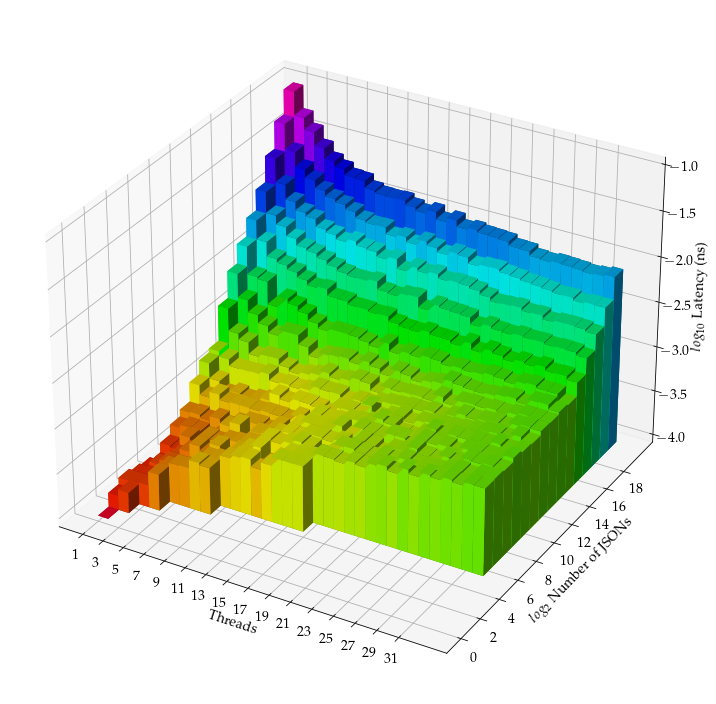

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import cmasher as cmr

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 14
})

threads = df.index.unique().to_numpy()
jsons = df.JSONs.unique()

xs = df.index.to_numpy()
ys = np.log2(df.JSONs.to_numpy())
zs = np.log10(df.Total.to_numpy())

bottom = zs.min()
top = zs.max()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))
#ax.invert_xaxis()

cmap = plt.get_cmap('gist_rainbow')
colors = list(map(lambda x: cmap(round((x - bottom)/(top - bottom) * 255)), zs))

ax.bar3d(x=xs, y=ys, z=bottom, dx=1, dy=1, dz=zs-bottom, color=colors)

#ax.scatter(xs=xs, ys=ys, zs=zs, c=colors)
#for i in range(0, len(xs)):
#    ax.plot(xs=[xs[i], xs[i]], ys=[ys[i], ys[i]], zs=[bottom, zs[i]], c=colors[i], alpha=0.25)

ax.set_zlim(bottom, top)
ax.set_xticks(range(min(xs),max(xs)+1,2))
ax.set_yticks(range(round(min(ys)),round(max(ys))+1,2))

ax.set_ylabel('$log_{2}$ Number of JSONs')
ax.set_xlabel('Threads')
ax.set_zlabel('$log_{10}$ Latency (ns)')

#ax.view_init(35.264, -135)

plt.tight_layout()